Importing the necessary libraries and packages

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

print('\n------------------Installing Optuna------------------')
print('--------------for hyperparameter tuning--------------\n')

%pip install optuna -q -q -q --no-input
print('\n\t\t\tDone!\n\n')

import optuna


------------------Installing Optuna------------------
--------------for hyperparameter tuning--------------


			Done!




Downloading the MNIST dataset from PyTorch torchvision datasets and splitting them into training and testing sets

In [ ]:
train_dataset = MNIST(
    root = 'data/',
    train = True,
    download = True,
    transform = ToTensor()
    )


Checking the size of the training dataset

In [ ]:
print(train_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()


To validate the data while training over multiple epochs, the following function splits the training dataset into training and validation on the basis of provided validation percentage

In [ ]:
#splitting validation set function
def split_index(size, val_pct, seed):
  n_val = int(size*val_pct)
  np.random.seed(seed)
  index = np.random.permutation(size)
  return (index[n_val:], index[:n_val])  
  #training and validation respectively

In [ ]:
#initialising a seed value for the random function

seed = 40

train_idx, val_idx = split_index(len(train_dataset), 0.2, seed)

print('Length of the whole dataset : ', len(train_dataset))
print('Length of training set :', len(train_idx))
print('Length of validation set :', len(val_idx))


Length of the whole dataset :  60000
Length of training set : 48000
Length of validation set : 12000


Defining the batchsize for the dataset and forming separate PyTorch DataLoaders for training, vaidation and testing

In [ ]:
#creating PyTorch DataLoaders for training and validation

#defining the data batch size
batchsize = 40

#randomly sampling the data for training using the previously defined training indices
sample_train = SubsetRandomSampler(train_idx)
#forming the training DataLoader
train_dl = DataLoader(train_dataset, batchsize, sampler = sample_train)

#randomly sampling the data for validation using the previously defined validation indices
sample_val = SubsetRandomSampler(val_idx)
#forming the training DataLoader
valid_dl = DataLoader(train_dataset, batchsize, sampler = sample_val)


Visualising one batch of training input

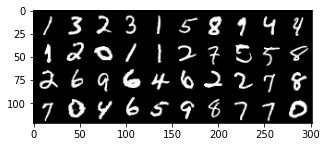

In [ ]:
from torchvision.utils import make_grid

def print_batch(dl):
  for img, labels in dl:
    fig, ax = plt.subplots(figsize = (5,5))
    ax.imshow(make_grid(img, 10).permute(1,2,0))
    break

print_batch(train_dl)

Input image dimensions and number of prediction classes

In [ ]:
img_size = 28*28
predict_classes = 10



Defining the convolutional neural network model. Using a simple nn.Sequential model with multiple 2d convolutional layers. The input size after each layer is mentioned as comments. The output is flattened after convolution and is put through a fully connected layer resulting in an output of seze = predict_classes.

The model is defined using the build_model function which takes the Optuna parameter dictionary as an input.

In [ ]:
def build_model(params):

  in_channel = 1

  return nn.Sequential(
      
      nn.Conv2d(in_channel,params['n_filter_1'],kernel_size = 3, stride = 1, padding = 3),
      nn.ReLU(),
      nn.MaxPool2d(2,2),

      nn.Conv2d(params['n_filter_1'],params['n_filter_2'],kernel_size = 3, stride = 1, padding = 1),
      nn.ReLU(),
      nn.MaxPool2d(2,2),

      nn.Conv2d(params['n_filter_2'],params['n_filter_3'],kernel_size = 3, stride = 1, padding = 1),
      nn.ReLU(),
      nn.MaxPool2d(2,2),

      nn.Conv2d(params['n_filter_3'],params['n_filter_4'],kernel_size = 3, stride = 1, padding = 1),
      nn.ReLU(),
      nn.MaxPool2d(2,2),

      nn.Conv2d(params['n_filter_4'],params['n_filter_5'],kernel_size = 3, stride = 1, padding = 1),
      nn.ReLU(),
      nn.MaxPool2d(2,2),

      nn.Flatten(),
      nn.Linear(params['n_filter_5'],10),
      
  )

* default_device checks whether GPU is available on the system or not and returns the appropriate result.

* to_device takes a tensor or a list of tensors and the device as input and moves the former to the device.

* DeviceDataLoader is a class which moves the data from the previously defined dataloaders to the device per batch.

In [ ]:
def default_device():
  #Selects GPU if it is available, otherwise CPU
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')


def to_device(t, device):
  #Moves the tensor t to the chosen device
  #the data can be a tensor or a list/tuple of tensors

  if isinstance(t, (list,tuple)):
    return [to_device(i,device) for i in t]
  return t.to(device, non_blocking = True)


class DeviceDataLoader():
  #moving data to the device only when that batch is called
  #This is done instead of the whole batch so that the large dataset does not waste GPU memory

  def __init__(self, dl,device):
    super().__init__()
    self.dl = dl
    self.device = device

  def __iter__(self):
    #yields a batch of data after transferring it to the device
    for i in self.dl:
      yield to_device(i, self.device)

  def __len__(self):
    #number of batches
    return len(self.dl)


In [ ]:
device = default_device()
if (device == torch.device('cuda')):
  print('Using a GPU (Cuda available)')
else:
  print('Using CPU (Cuda unavailable)')

Using a GPU (Cuda available)


The accuracy function defines the accuracy metric which determines how the model functions overall. It checks the predictions with the labels and returns a percentage of the accurate predictions

In [ ]:
def accuracy(outputs, labels):
  _,preds = torch.max(outputs, dim = 1)
  return (torch.sum(preds == labels).item()/len(preds))   

the loss_batch function is defined which calculates the loss for a particular batch with respect to the provided loss function. If the optimiser is provided, this function conducts the backward propagation for the model parameters and updates them based on the learning rate for each iteration. The loss, and length of the data are returned


In [ ]:
def loss_batch(model, loss_fn, x, y, opt = None, metric = None):

  #for a given optimiser function:
  if opt is not None:
    # get the inputs; data is a list of [inputs, labels]
    # zero the parameter gradients
    opt.zero_grad()
    # forward + backward + optimize
    preds = model(x)
    loss1 = loss_fn()
    loss = loss1(preds, y)
    loss.backward()
    opt.step()

  else: 
    preds = model(x)
    loss1 = loss_fn()
    loss = loss1(preds, y)

  metric_result = None
  if metric is not None:
    metric_result = metric(preds,y)

  return loss.item(), len(x), metric_result

The evaluate function is defined which calculates the average loss of the validation dataset per epoch, while training the model

In [ ]:
def evaluate(model, loss_fn, valid_dl, metric = None):
    
  #evaluating each batch through the model
  predictions = [loss_batch(model, loss_fn, x, y, metric = metric) for x, y in valid_dl]

  #saving the losses, counts and metrics as separate lists
  losses, counts, metrics = zip(*predictions)
    
  #total size of the dataset
  size = np.sum(counts)

  #calculating the average loss
  avg_loss = np.sum(np.multiply(losses,counts))/size

  avg_metric = None
  if metric is not None:
    avg_metric = np.sum(np.multiply(metrics,counts))/size

  #returning average loss, total size
  return avg_loss, size, avg_metric
  

The Optuna parameters are defined using the objective() function, and the model is built using these parameters. This model is passed through the fit() function which trains and validates the model for a given number of epochs and then returns the accuracy value of the last epoch, which will be the metric Optuna will optimise for. A new Optuna study is then created in memory which optimises the parameters for maximising the accuracy. The total number of trials are set manually.

In [ ]:
def fit(param,epochs, model, train_dl, valid_dl, metric = None):

  train_dl = DeviceDataLoader(train_dl, device)
  valid_dl = DeviceDataLoader(valid_dl, device)
  to_device(model, device)

  val_metrics = []

  loss_fn = nn.CrossEntropyLoss
  opt = getattr(optim, param['optimizer'])(model.parameters(), lr= param['learning_rate'])

  for epoch in range(epochs): 
    model.train()
    for x,y in train_dl:
      train_loss,_,_ = loss_batch(model, loss_fn, x, y, opt)
    model.eval()
    with torch.no_grad():
      results = evaluate(model,loss_fn,valid_dl, metric = metric)
      val_loss,size,val_metric = results
      val_metrics.append(val_metric)
    
  return val_metrics[-1]


def objective(trial):

  params = {
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-7, 1e-1),
            'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]),
            'n_filter_1': trial.suggest_int("n_filter_1", 4, 16),
            'n_filter_2': trial.suggest_int("n_filter_2", 10, 20),
            'n_filter_3': trial.suggest_int("n_filter_3", 15, 30),
            'n_filter_4': trial.suggest_int("n_filter_4", 22, 44),
            'n_filter_5': trial.suggest_int("n_filter_5", 33, 66)
           }

  model = build_model(params)

  epochs = 5
  accuracy_fin = fit(params,epochs, model, train_dl, valid_dl, metric = accuracy)

  return accuracy_fin

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=10)

[I 2022-06-25 13:30:03,710] A new study created in memory with name: no-name-52a06277-2c65-45be-bf1f-dd5101f0a381
[I 2022-06-25 13:30:57,967] Trial 0 finished with value: 0.20483333333333334 and parameters: {'learning_rate': 1.3818104838784747e-06, 'optimizer': 'RMSprop', 'n_filter_1': 8, 'n_filter_2': 16, 'n_filter_3': 25, 'n_filter_4': 42, 'n_filter_5': 42}. Best is trial 0 with value: 0.20483333333333334.
[I 2022-06-25 13:31:48,353] Trial 1 finished with value: 0.9745833333333334 and parameters: {'learning_rate': 0.007244515189522473, 'optimizer': 'Adam', 'n_filter_1': 11, 'n_filter_2': 15, 'n_filter_3': 22, 'n_filter_4': 37, 'n_filter_5': 38}. Best is trial 1 with value: 0.9745833333333334.
[I 2022-06-25 13:32:33,502] Trial 2 finished with value: 0.9755 and parameters: {'learning_rate': 0.0012911706311217075, 'optimizer': 'RMSprop', 'n_filter_1': 6, 'n_filter_2': 20, 'n_filter_3': 24, 'n_filter_4': 36, 'n_filter_5': 57}. Best is trial 2 with value: 0.9755.
[I 2022-06-25 13:33:16,17

After Optuna is finished optimising the parameters for maximum accuracy, the best trial parameters are saved in the Optuna study as a dictionary and can be called forth to evaluate the final model.

In [ ]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

learning_rate: 0.002112681875072982
optimizer: RMSprop
n_filter_1: 8
n_filter_2: 15
n_filter_3: 29
n_filter_4: 23
n_filter_5: 50


Checking the initial losses and accuracy before beginning the training procedure

In [ ]:
params_final = best_trial.params

final_model = build_model(params_final)

init_val_loss,_,init_val_accuracy = evaluate(final_model, nn.CrossEntropyLoss, valid_dl, metric = accuracy)
init_train_loss,_,_ = evaluate(final_model, nn.CrossEntropyLoss, train_dl, metric = accuracy)

print('Initial validation loss = {:.3f}'.format(init_val_loss))
print('Initial training loss = {:.3f}'.format(init_train_loss))

print('\nInitial validation accuracy = {:.3f} %'.format(init_val_accuracy*100))


Initial validation loss = 2.307
Initial training loss = 2.307

Initial validation accuracy = 10.325 %


The train_model function runs for a specified number of epochs. it defines the loss function (cross entropy loss in this case). The optimizer is loaded with the model parameters and provided learning rate. The model trains over the training dataloader and calls the loss_batch function, and then subsequently is evaluated over the validation dataloader by calling the evaluate function to calculate the average validation loss and accuracy for each epoch.

In [ ]:
def train_model(param, epochs, model, train_dl, valid_dl):

  train_dl = DeviceDataLoader(train_dl, device)
  valid_dl = DeviceDataLoader(valid_dl, device)

  to_device(model, device)

  train_losses = []
  val_losses = []
  val_metrics = []

  metric = accuracy
  
  loss_fn = nn.CrossEntropyLoss
  opt = getattr(optim, param['optimizer'])(model.parameters(), lr= param['learning_rate'])


  for epoch in range(epochs):  # loop over the dataset multiple times
    model.train()
    for x,y in train_dl:
      # get the inputs; data is a list of [inputs, labels]
      # zero the parameter gradients
      train_loss,_,_ = loss_batch(model, loss_fn, x, y, opt)
      
    model.eval()
    results = evaluate(model,loss_fn,valid_dl, metric = metric)
    val_loss,size,val_metric = results

    #saving the losses for each epoch as a list
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_metrics.append(val_metric)


    # printing the validation loss for each 100 epochs

    if epoch % 1 == 0:
      print('Epoch [{}/{}], train_loss: {:.3f}, val_loss: {:.3f}, val_accuracy: {:.3f} %'.format(epoch+1,epochs, train_loss, val_loss, val_metric*100))


  print('Finished Training!')
  
  print('\nFinal training loss = {:.3f} %'.format(train_losses[-1]))
  print('Final validation loss = {:.3f} %'.format(val_losses[-1]))
  print('Final validation accuracy = {:.3f} %'.format(val_metrics[-1]*100))


  #returning the list containing the losses
  return train_losses, val_losses, val_metrics

In [ ]:
epochs = 10

train_losses, val_losses, val_metrics = train_model(params_final, epochs, final_model, train_dl, valid_dl)

Epoch [1/10], train_loss: 0.375, val_loss: 0.330, val_accuracy: 89.867 %
Epoch [2/10], train_loss: 0.046, val_loss: 0.075, val_accuracy: 97.833 %
Epoch [3/10], train_loss: 0.041, val_loss: 0.061, val_accuracy: 98.200 %
Epoch [4/10], train_loss: 0.016, val_loss: 0.050, val_accuracy: 98.525 %
Epoch [5/10], train_loss: 0.002, val_loss: 0.052, val_accuracy: 98.500 %
Epoch [6/10], train_loss: 0.003, val_loss: 0.065, val_accuracy: 98.175 %
Epoch [7/10], train_loss: 0.131, val_loss: 0.067, val_accuracy: 98.125 %
Epoch [8/10], train_loss: 0.023, val_loss: 0.059, val_accuracy: 98.342 %
Epoch [9/10], train_loss: 0.306, val_loss: 0.070, val_accuracy: 98.033 %
Epoch [10/10], train_loss: 0.032, val_loss: 0.051, val_accuracy: 98.558 %
Finished Training!

Final training loss = 0.032 %
Final validation loss = 0.051 %
Final validation accuracy = 98.558 %


In [ ]:
init_val_loss,_,init_val_accuracy = evaluate(final_model, nn.CrossEntropyLoss, valid_dl, metric = accuracy)

print('Initial validation loss = {:.3f}'.format(init_val_loss))

print('\nInitial validation accuracy = {:.3f} %'.format(init_val_accuracy*100))

Initial validation loss = 0.051

Initial validation accuracy = 98.558 %


Generating plots to show the increase in the validation accuracy and the decrease in validation and training losses with increasing number of epochs. Since the MNIST dataset is a relatively simple dataset with only one channel per image, we can see that the the accuracy increases sharply in just one epoch and the training and validation losses decrease just as sharply.


Plotting the change in accuracy and loss with increasing number of epochs



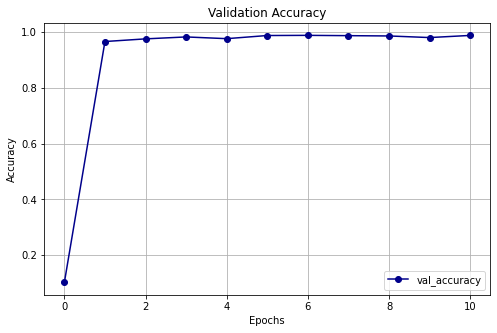

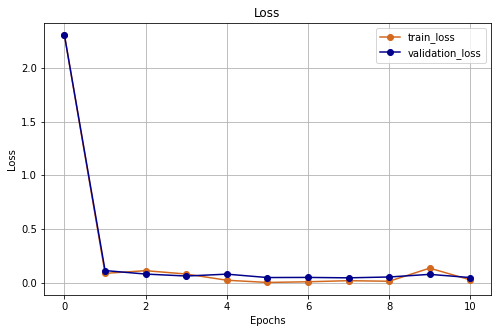

In [ ]:
print('\nPlotting the change in accuracy and loss with increasing number of epochs\n')
epochs_list = [0]+[i+1 for i in range(epochs)]
plt.figure(figsize = (8,5))
#adding in the initial accuracy value to see the change in the 1st epoch
acc_values = [init_val_accuracy] + val_metrics
plt.plot(epochs_list, acc_values, color = 'darkblue', marker = '.', markersize = 12, label = 'val_accuracy')


plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()


print('\n')

plt.figure(figsize = (8,5))
#adding in the initial loss values to see the change in the 1st epoch
loss_values_train = [init_train_loss] + train_losses
loss_values_val = [init_val_loss] + val_losses
plt.plot(epochs_list, loss_values_train, color = 'chocolate', marker = '.', markersize = 12, label = 'train_loss')
plt.plot(epochs_list, loss_values_val, color = 'darkblue', marker = '.', markersize = 12, label = 'validation_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()


Saving the model to drive for convenience

In [ ]:
FILE = "/content/drive/MyDrive/MODELS/mnist_cnn_optuna.pth"
torch.save(final_model, FILE)  

FileNotFoundError: ignored

To test the trained model on unseen data, the test dataset is formed and made into a PyTorch DataLoader. The trained model is loaded from drive and is evaluated for the first 5 inputs, showing accurate predictions. The inputs, labels and predicted outputs are printed.

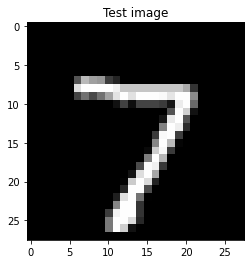


Known label is:  7
The predicted label is:  7




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


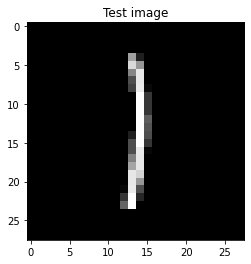


Known label is:  1
The predicted label is:  1




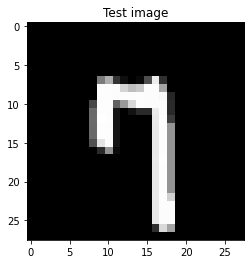


Known label is:  7
The predicted label is:  7




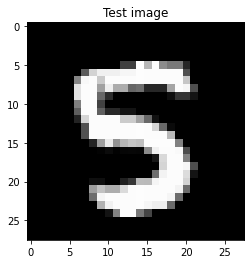


Known label is:  5
The predicted label is:  5




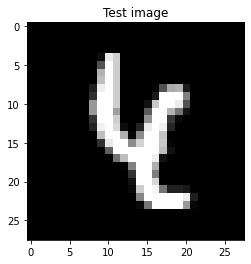


Known label is:  4
The predicted label is:  4




In [ ]:
test_dataset = MNIST(
    root = 'data/',
    train = False,
    download = True,
    transform = ToTensor()
    )

#forming the test DataLoader
test_dl = DataLoader(test_dataset, batchsize, shuffle = True)


#import torch
#FILE = "/content/drive/MyDrive/MODELS/mnist_cnn_optuna.pth"
#model = torch.load(FILE)

device = torch.device('cpu')
model_cpu = final_model.to(device)

counter = 0

for images, labels in test_dl:
  
  model_cpu.eval()
  if counter == 5:
    break

  #moving model back to CPU for testing+
  out = model_cpu(images)
  
  print_image = images[0]
  print_label = labels[0]

  #showing the input image
  plt.figure()
  plt.imshow(print_image[0], cmap = 'gray')
  plt.title('Test image')
  plt.show()

  print('\nKnown label is: ', print_label.item())

  probs = list((F.softmax(out[0])).flatten().detach().numpy())
  prediction = probs.index(max(probs))

  print('The predicted label is: ', prediction)
  print('\n')

  counter += 1